# Quantum Computing: Lab 4



In [1]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit, transpile, execute, BasicAer, Aer
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import *

from qiskit.optimization.applications.ising import max_cut
from qiskit.optimization.applications.ising.common import sample_most_likely

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, QAOA, VQC
from qiskit.aqua.components.optimizers import COBYLA, AQGD
from qiskit.aqua.circuits import StateVectorCircuit


from qiskit.visualization import plot_histogram

from matplotlib import pyplot as plt

from sklearn import preprocessing
import networkx as nx

/opt/conda/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/opt/conda/lib/python3.9/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


## Quantum Machine Learning

In the second part of the lab, I will show you different ways of implementing a quantum neural network or rather a variational quantum classifier. For the lab we will use the same 'Iris' [dataset](https://www.kaggle.com/uciml/iris). Remember, that we work with a preprocessed dataset. Meaning, that we have already normalized all features to the range 0 to 1, which we do almost always in classical machine learning. (This is not the l2-norm)

In [2]:
x = np.array([0.35, 0.75, 0.15, 0.1])

Using the `preprocessing` module from `sklearn`, we can normalize our features to the l2-norm.

In [3]:
x_l2norm = preprocessing.normalize(x.reshape(1, -1), norm='l2') # we have to reshape it, since it expects a list of features instead of one sample
print(x_l2norm)

[[0.41319694 0.885422   0.1770844  0.11805627]]


Having the amplitudes we can start with the amplitude encoding. However, in this lab we will use the `StateVectorCircuit`, which is built in to qiskit instead of the circuit from the lecture.

/tmp/ipykernel_624/3426139698.py:1: DeprecationWarning: The StateVectorCircuit class is deprecated as of Qiskit Aqua 0.9.0 and will be removed no earlier than 3 months after the release. If you need to initialize a circuit, use the QuantumCircuit.initialize or QuantumCircuit.isometry methods. For a parameterized initialization, try the qiskit.ml.circuit.library.RawFeatureVector class.
  state_vector_circuit = StateVectorCircuit(x_l2norm[0]).construct_circuit()


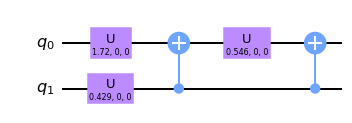

In [4]:
state_vector_circuit = StateVectorCircuit(x_l2norm[0]).construct_circuit()

state_vector_circuit.draw('mpl', fold=-1)

In [5]:
job = execute(state_vector_circuit, BasicAer.get_backend('statevector_simulator'))
result = job.result()

print(result.get_statevector())

[0.41319694+0.j 0.885422  +0.j 0.1770844 +0.j 0.11805627+0.j]


In the following we create a parameterized circuit, which serves as our neural network. Notice, that we use a `ParameterVector` this time. I have chosen to use 6 layers. As you can see each layer persists of the Rotation-Gate, which you have seen in the lecture, on each qubit and a CNOT-Gate. As in the lecture I have decomposed the [Rotation-Gate](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.Rot.html) into a RZ-, RY- and a RZ-Gate. 

In [6]:
w = ParameterVector('w', 36)

/opt/conda/lib/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


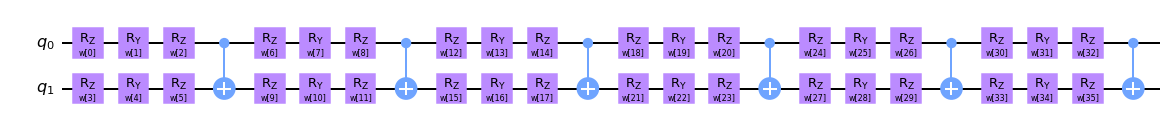

In [7]:
nn_circ = QuantumCircuit(2)

for i in range(0, 36, 6):
    nn_circ.rz(w[i], 0)
    nn_circ.ry(w[i+1], 0)
    nn_circ.rz(w[i+2], 0)
    
    nn_circ.rz(w[i+3], 1)
    nn_circ.ry(w[i+4], 1)
    nn_circ.rz(w[i+5], 1)
    
    nn_circ.cx(0, 1)

nn_circ.draw('mpl', fold=-1)

In the following we load the classically preprocessed dataset and split it into features and their corresponding labels. The features are then normalized to the l2-norm.

In [8]:
data = np.loadtxt("resources/iris_classes1and2_scaled.txt")
X = data[:, 0:4]
X_norm = preprocessing.normalize(X, norm='l2')

Y = data[:, -1]

print(X[40])
print(X_norm[40])
print(Y[40])

[0.35 0.75 0.15 0.1 ]
[0.41319694 0.885422   0.1770844  0.11805627]
-1.0


Next we split our dataset into traing and validation data. Remember, we use the validation dataset, which is not learned by the artificial intelligence, to check how good it can generalize from the given data.

In [9]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = X_norm[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = X_norm[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

pos_features = []
neg_features = []

for i in range(len(feats_train)):
    if Y_train[i] < 0:
        neg_features.append(feats_train[i])
    else:
        pos_features.append(feats_train[i])
        
training_dataset = {'+1': np.array(pos_features), '-1': np.array(neg_features)}

The next code block creates a python class from the `StateVectorCircuit`, which is compatible to qiskits `VQC` class.

In [10]:
class StateVectorFeatureMap(qiskit.aqua.components.feature_maps.FeatureMap):
    def __init__(self, num_qubits):
        self._num_qubits = num_qubits
        self._feature_dimension = 2**num_qubits
        self._support_parameterized_circuit = False
        
    def construct_circuit(self, x, qr=None, inverse=False):
        if qr is not None:
            return StateVectorCircuit(x).construct_circuit(register=qr)
        else:
            return StateVectorCircuit(x).construct_circuit()

Here we use the `VQC` class to train the quantum machine learning model with the training dataset. We use again the `COBYLA` optimzier. However, as mentioned before one should check which of the optimizers works the best for their problem.

In [11]:
vqc = VQC(optimizer=COBYLA(maxiter=65), feature_map=StateVectorFeatureMap(2), var_form=nn_circ, training_dataset=training_dataset, quantum_instance=BasicAer.get_backend('qasm_simulator'))

/opt/conda/lib/python3.9/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',
/opt/conda/lib/python3.9/site-packages/qiskit/aqua/algorithms/classifiers/vqc.py:96: DeprecationWarning: The package qiskit.aqua.algorithms.classifiers is deprecated. It was moved/refactored to qiskit_machine_learning.algorithms.classifiers (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.classifiers',
/opt/conda/lib/python3.9/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:70: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was mov

In [12]:
vqc.run()

/opt/conda/lib/python3.9/site-packages/qiskit/aqua/algorithms/quantum_algorithm.py:46: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return aqua_globals.random
/opt/conda/lib/python3.9/site-packages/qiskit/ml/__init__.py:40: DeprecationWarning: The package qiskit.ml is deprecated. It was moved/refactored to qiskit_machine_learning (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('ml', 'qiskit_machine_learning', 'qiskit-machine-learning')
/tmp/ipykernel_624/1295517892.py:9: DeprecationWarning: The StateVectorCircuit class is deprecated as of Qiskit Aqua 0.9.0 and will be removed no earlier than 3 months after the release. If you need to initialize a circuit, use the Quan

{'num_optimizer_evals': 65,
 'min_val': 0.12974048208975175,
 'opt_params': array([-1.24465379, -0.33938032, -0.18896467,  0.3924653 , -0.3516063 ,
         0.80340582,  0.81099259,  1.30291575, -0.47495705, -0.12002167,
        -0.50098428, -0.00462177, -1.20926645,  0.38435784,  0.87851339,
         0.01501593,  0.70350275,  0.83357505,  1.20557477,  0.29377917,
         0.2327638 , -1.29467384,  0.91613201, -0.78536793, -0.88184651,
         2.10169514,  2.18442336, -2.79619495, -1.52228651,  0.77709278,
        -1.14231164,  0.17812946, -0.69709354, -1.36338983, -0.42146998,
        -1.84858284]),
 'eval_time': 291.6336545944214,
 'eval_count': 65,
 'training_loss': 0.12974048208975175}

We can check, that we predict the example from the lecture correctly.

In [13]:
vqc.predict(np.array([X_norm[40]]))

/tmp/ipykernel_624/1295517892.py:9: DeprecationWarning: The StateVectorCircuit class is deprecated as of Qiskit Aqua 0.9.0 and will be removed no earlier than 3 months after the release. If you need to initialize a circuit, use the QuantumCircuit.initialize or QuantumCircuit.isometry methods. For a parameterized initialization, try the qiskit.ml.circuit.library.RawFeatureVector class.
  return StateVectorCircuit(x).construct_circuit(register=qr)


(array([[0.06933594, 0.93066406]]), array([1]))

Notice, that our dataset has only the labels '+1' and '-1'. If you look in the dataset you notice, that '-1' and thus $1$ is the correct solution.

In [14]:
vqc.class_to_label

{'+1': 0, '-1': 1}

/opt/conda/lib/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


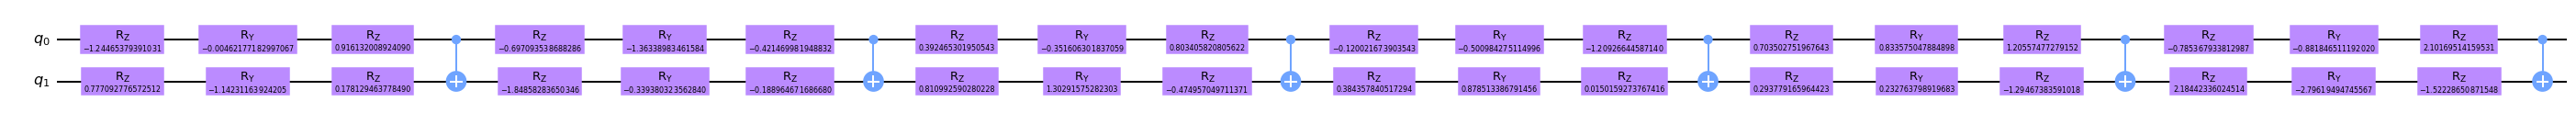

In [15]:
vqc.get_optimal_circuit().draw('mpl', fold=-1)

In [16]:
Y_val_labels = []

for i in range(len(Y_val)):
    if Y_val[i] < 1:
        Y_val_labels.append(1)
    else:
        Y_val_labels.append(0)

Y_val_labels = np.array(Y_val_labels)

In [17]:
vqc.test(feats_val, Y_val_labels)

/tmp/ipykernel_624/1295517892.py:9: DeprecationWarning: The StateVectorCircuit class is deprecated as of Qiskit Aqua 0.9.0 and will be removed no earlier than 3 months after the release. If you need to initialize a circuit, use the QuantumCircuit.initialize or QuantumCircuit.isometry methods. For a parameterized initialization, try the qiskit.ml.circuit.library.RawFeatureVector class.
  return StateVectorCircuit(x).construct_circuit(register=qr)


1.0

As with QAOA we can use also inbuilt classes to make the creation of a quantum neural network easier. However, the feature maps in qiskit are not using amplitude enconding to reduce the depth (number of gates) of the circuit. Thus, we need $n$ qubits for $n$ features instead of $\log{n}$ qubits.

In [18]:
feature_map = ZZFeatureMap(4)
ansatz = RealAmplitudes(4, reps=3)

In [19]:
vqc = VQC(optimizer=COBYLA(maxiter=65), feature_map=feature_map, var_form=ansatz, training_dataset=training_dataset, quantum_instance=BasicAer.get_backend('qasm_simulator'))

In [20]:
vqc.run()

{'num_optimizer_evals': 65,
 'min_val': 0.3638026723139972,
 'opt_params': array([ 1.93997999,  0.4795538 ,  0.15210119, -0.77453676,  1.21098889,
        -0.10939772,  1.1723083 ,  0.80976598,  0.18376584, -1.21528409,
         0.51506043,  0.36364216, -1.69528653,  1.77674457,  0.89092289,
         0.80132561]),
 'eval_time': 68.2421247959137,
 'eval_count': 65,
 'training_loss': 0.3638026723139972}

In [21]:
vqc.class_to_label

{'+1': 0, '-1': 1}

In [22]:
vqc.predict(np.array([X_norm[40]]))

(array([[0.19433594, 0.80566406]]), array([1]))

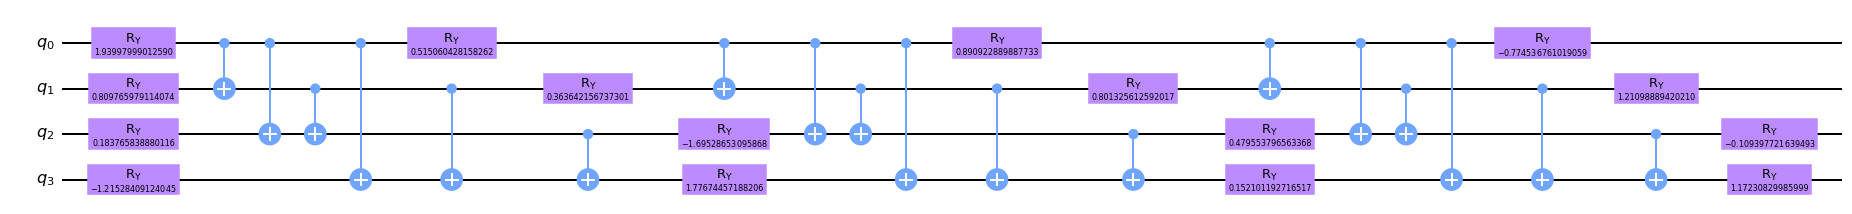

In [24]:
vqc.get_optimal_circuit().decompose().draw('mpl', fold=-1)